# 2301865741 - Edgard Jonathan Putra Pranoto

# Import Some Library that will be used

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import emoji
import nltk
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from transformers import BertTokenizerFast
from transformers import TFBertModel

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# **4. A. Performing preprocess and prepare the dataset using BertTokenizer**

# Read .csv file containing the dataset

In [2]:
train_dataset = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding="ISO-8859-1")
test_dataset = pd.read_csv('../input/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding="ISO-8859-1")

print(train_dataset.head())
print(test_dataset.head())

   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  
   UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3        

**Since we only need the original tweet and the sentiment for the classification, we will drop other column**

In [3]:
train_dataset = train_dataset[['OriginalTweet','Sentiment']]
test_dataset = test_dataset[['OriginalTweet','Sentiment']]

# Creating Function for Cleaning/Preprocessing

Since there are so many things in the tweet that could create noise, i tried to clean the data using some preprocessing. List of the preprocessing that has been done to the dataset could be seen below:
* Removing links such as https://.... , http://.... , etc
* Removing hashtags 
* Removing user mention
* Removing unnecessary character (non alphanumeric except aposthrope)
* Removing extra whitespace
* Removing emoji unicode such as \xF0\x9F\x98\x81, \xF0\x9F\x98\x82, etc
* Lastly, Removing leading and trailing space

In the cleaning step i used regex which is a set of characters that specify a pattern in a text
detail for each line of code/regex could be seen in the comment below

In [4]:
def cleaner(tweet):
    # remove links
    tweet = "".join(re.sub("(\w+:\/\/\S+)"," ", tweet))
    
    # remove hashtags
    tweet = "".join(re.sub("(#[A-Za-z0-9_]+)"," ", tweet))
    
    # remove user mention
    tweet = "".join(re.sub("(@[A-Za-z0-9_]+)"," ", tweet))
    
    # remove none alphanumeric and aposthrope
    tweet = "".join(re.sub("([^0-9A-Za-z \t'])"," ", tweet))
    
    # remove extra whitespace
    tweet = " ".join(tweet.split())
    
    # remove emoji unicode 
    tweet = "".join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    
    # remove leading and trailing space
    tweet = tweet.strip()
    return tweet

**Applying cleaning process for all tweet both in train_dataset and test_dataset**

In [5]:
train_dataset['OriginalTweet'] = train_dataset['OriginalTweet'].apply(lambda x: cleaner(x))
test_dataset['OriginalTweet'] = test_dataset['OriginalTweet'].apply(lambda x: cleaner(x))
print(train_dataset.head())
print(test_dataset.head())

                                       OriginalTweet           Sentiment
0                                            and and             Neutral
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia Woolworths to give elder...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me ready to go at supermarket during the outbr...  Extremely Negative
                                       OriginalTweet           Sentiment
0  TRENDING New Yorkers encounter empty supermark...  Extremely Negative
1  When I couldn't find hand sanitizer at Fred Me...            Positive
2  Find out how you can protect yourself and love...  Extremely Positive
3  buying hits City as anxious shoppers stock up ...            Negative
4  One week everyone buying baby milk powder the ...             Neutral


**Removing Tweet that are less than or equal to 5 words**

Since i did some cleaning to the dataset, there is a possibility that after the cleaning is done there will be a tweet with small count of word. Therefore, i decided to drop these rows since it might not contains any information.

In [6]:
train_dataset = train_dataset[train_dataset['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]
test_dataset = test_dataset[test_dataset['OriginalTweet'].apply(lambda x: len(x.split()) > 5)]
print(train_dataset.head())
print(test_dataset.head())

                                       OriginalTweet           Sentiment
1  advice Talk to your neighbours family to excha...            Positive
2  Coronavirus Australia Woolworths to give elder...            Positive
3  My food stock is not the only one which is emp...            Positive
4  Me ready to go at supermarket during the outbr...  Extremely Negative
5  As news of the region s first confirmed COVID ...            Positive
                                       OriginalTweet           Sentiment
0  TRENDING New Yorkers encounter empty supermark...  Extremely Negative
1  When I couldn't find hand sanitizer at Fred Me...            Positive
2  Find out how you can protect yourself and love...  Extremely Positive
3  buying hits City as anxious shoppers stock up ...            Negative
4  One week everyone buying baby milk powder the ...             Neutral


**After i work with the tweets, next i convert the label from the dataset into integer**

The converted label will be
* 0: Extremely Negative
* 1: Negative
* 2: Neutral
* 3: Positive
* 4: Extremely Positive

In [7]:
train_dataset['Sentiment'] = train_dataset['Sentiment'].map(\
             {'Extremely Negative':0,'Negative':1,'Neutral':2,'Positive':3,'Extremely Positive':4})
test_dataset['Sentiment'] = test_dataset['Sentiment'].map(\
            {'Extremely Negative':0,'Negative':1,'Neutral':2,'Positive':3,'Extremely Positive':4})

In [8]:
train_dataset['Sentiment'].value_counts()

3    11243
1     9793
2     7208
4     6608
0     5460
Name: Sentiment, dtype: int64

# Splitting Train Dataset into train dataset and validation dataset

Since the dataset given already contains test data which have around 3800 tweets and its label. I splitted the train data to get validation dataset, I splitted the data with 90% for training and 10% validation. I choose 10% since the amount of validation data will be similar with the test data.

In [9]:
x_train = train_dataset['OriginalTweet'].values
y_train = train_dataset['Sentiment'].values
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=43)
x_test = test_dataset['OriginalTweet'].values
y_test = test_dataset['Sentiment'].values

print(f"Train Count: {x_train.shape[0]}\nValidation Count: {x_valid.shape[0]}\nTest Count: {x_test.shape[0]}" )

Train Count: 36280
Validation Count: 4032
Test Count: 3755


**Converting labels into onehot representation**

This is done because there are more than 2 class of data. If we don't use one hot encoding the prediction later will be between 2 class, therefore i used one hot encoding so later on the prediction of the model will be the probability for each 1 from 5 class and not only between 2 classes.

In [10]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(36280, 5)
(4032, 5)
(3755, 5)


# BertTokenizer

In NLP, tokenizer is used to break down a whole sentence into word (sentence to word) and this could be done just by splitting the string. 

In BERT, before a sentence is fed into the network, each sentence will go through some step called BertTokenizer. 
1. Each sentence will be tokenized using an algorithm called wordpiece tokenizer. The difference between this algorithm with the usual one is not only each sentence will be splitted into a number of word. Each word later on will be splitted into a number of subword. This is done because of the limitation of vocabulary in the pretrained model, usually unknown vocabulary will be converted into [UNK] token / unknown. If there are many unknown token in the dataset, this will create an information loss. As an example: I am sleeping, in the regular tokenizer the word sleeping will stay as it is, but in the wordpiece algorithm, the word sleeping will be splitted into "sleep" and "##ing" which is more commonly seen in the vocabulary. 
2. Adding [CLS] in front of the string which means start of string
3. Adding [SEP] at the end of the string which means the end of the string
4. Adding [PAD] this is done if the string length is less than max length given in the input. Because the model only receive input with same length
5. Lastly, convert all token into corresponding ids.

In [11]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Defining Function to bert_tokenize all tweet in the dataset**

In [12]:
MAX_LEN=128

def bert_tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for tweet in data:
        encoded = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

**BertTokenize all of the dataset (train, validation, test)**

I used 128 as the max_len since its is close to the maximum word count in one tweet from this dataset.

In [13]:
train_input_ids, train_attention_masks = bert_tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = bert_tokenize(x_valid, MAX_LEN)
test_input_ids, test_attention_masks = bert_tokenize(x_test, MAX_LEN)

# **4. B. Develop the classifier and Train the model**

# Network Architecture

**Defining Bert Model that will be used as the encoder**

i used bert-base-uncased since it is smaller compared to the large one and will be faster to train.

In [14]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

2022-02-04 20:38:50.707330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 20:38:50.708366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 20:38:50.709029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-04 20:38:50.709912: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Defining Function to create the model

<a href="https://arxiv.org/pdf/1810.04805.pdf"> Paper </a>

    
In the model is used Adam Optimizer which is used by the creator of the pretrained model, using learning rate of 2e-5 which is recommended by the paper (5e-5, 4e-5, 3e-5, 2e-5). The loss function that will be used is CategoricalCrossentropy since the task is multiclass classification (one prediction from 5 class). The accuracy metrics that i used is CategoricalAccuracy since the output will be vector of [5,1].

The model will be:
Input (id and mask) -> Bert -> dropout layer (0,2 dropout to reduce overfitting) -> Output (Dense with Softmax function which is recommended for multiclass classification)

In [15]:
def create_model(bert_model, max_len=MAX_LEN):
    
    # parameter
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    bert = bert_model([input_ids,attention_masks])[1]
    dropout = tf.keras.layers.Dropout(0.2)(bert)
    output = tf.keras.layers.Dense(5, activation="softmax")(dropout)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    model.compile(optimizer, loss=loss, metrics=accuracy)
    
    return model

**Creating the model and showing the model summary**

In [16]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           tf_bert_model[0][1]          

# Training the architecture

I trained the model for 10 loop using batch size of 32 and the epoch with best validation accuracy will be saved.

In [17]:
EPOCHS = 10
BATCH_SIZE = 32
checkpoint_filepath = '/BERT'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True)

train_history = model.fit([train_input_ids,train_attention_masks], 
                          y_train, 
                          validation_data=([val_input_ids,val_attention_masks], y_valid),
                          epochs=EPOCHS, 
                          batch_size=BATCH_SIZE,
                          callbacks=[model_checkpoint_callback])

2022-02-04 20:39:04.560487: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
1134/1134 [==============================] - 571s 490ms/step - loss: 0.8359 - categorical_accuracy: 0.6581 - val_loss: 0.4341 - val_categorical_accuracy: 0.8447
Epoch 2/10
1134/1134 [==============================] - 555s 489ms/step - loss: 0.3994 - categorical_accuracy: 0.8546 - val_loss: 0.3381 - val_categorical_accuracy: 0.8760
Epoch 3/10
1134/1134 [==============================] - 552s 487ms/step - loss: 0.2646 - categorical_accuracy: 0.9061 - val_loss: 0.3245 - val_categorical_accuracy: 0.8864
Epoch 4/10
1134/1134 [==============================] - 553s 488ms/step - loss: 0.1881 - categorical_accuracy: 0.9326 - val_loss: 0.3456 - val_categorical_accuracy: 0.8795
Epoch 5/10
1134/1134 [==============================] - 554s 488ms/step - loss: 0.1469 - categorical_accuracy: 0.9486 - val_loss: 0.3623 - val_categorical_accuracy: 0.8822
Epoch 6/10
1134/1134 [==============================] - 556s 490ms/step - loss: 0.1102 - categorical_accuracy: 0.9609 - val_loss: 0.3766 - v

**Plotting the Training Metrics**

From the plot, i could see that the highest training gain is in epoch 1 and epoch 2. After that the accuracy stays between 87%-89%.

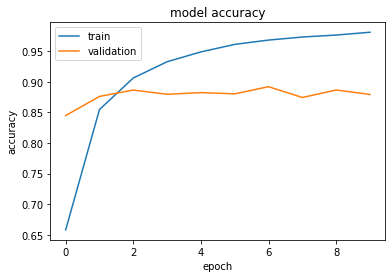

In [18]:
plt.plot(train_history.history['categorical_accuracy'])
plt.plot(train_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

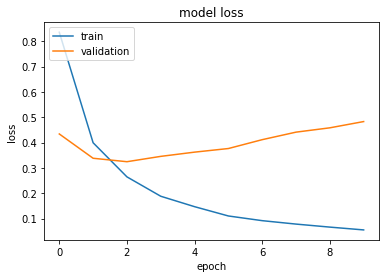

In [19]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# **Performance Analysis**

In [20]:
# model.load_weights(checkpoint_filepath)

y_pred = model.predict([test_input_ids,test_attention_masks])

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

**The model is evaluated using accuracy score, precision, recall, f1, and Confusion Matrix**

Accuracy: 86.55 


Classification Report,
                    precision    recall  f1-score   support

Extremely Negative       0.86      0.92      0.89       592
          Negative       0.85      0.85      0.85      1038
           Neutral       0.91      0.85      0.88       587
          Positive       0.87      0.83      0.85       939
Extremely Positive       0.86      0.92      0.89       599

          accuracy                           0.87      3755
         macro avg       0.87      0.87      0.87      3755
      weighted avg       0.87      0.87      0.87      3755



Confusion Matrix,


<AxesSubplot:>

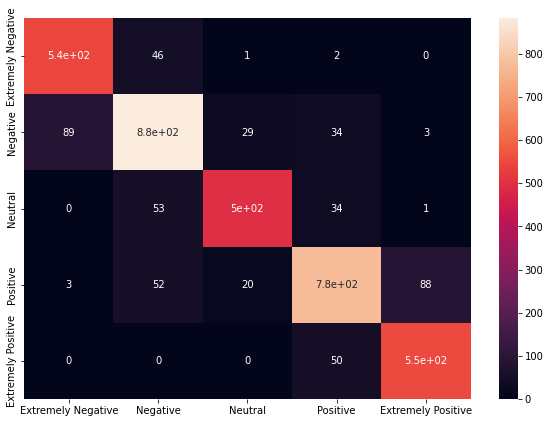

In [21]:
labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']

accuracy = accuracy_score(y_true=y_test, y_pred=y_pred) # Also gives the accuracy for the two lists actual and pred
print("Accuracy: %.2lf " % (accuracy*100))

print()
print()
print("Classification Report,")
print(classification_report(y_test,y_pred, target_names=labels))

print()
print()
print("Confusion Matrix,")
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = pd.DataFrame(cf_matrix, index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, annot=True)

# Conclusion

1. Based on the Accuracy, the model already achieved good result at 86% accuracy
2. Based on the Recall score, the model is having trouble in predicting an Extremely Negative Label
3. The statement in point 2 is strengthened with the evaluation from confusion matrix where the model misclassify  many Extremely Negative as Negative (about 110 missprediction which is the highest).
4. This might happen because the tweet in the dataset is not fully english (some of the tweet not in english).
5. Based on the classification Report the model already have a good result.
6. Further adjustment that could be made is cleaning the dataset to remove tweet that are not in english
7. Other adjustment could be made by adding more tweet in the label other than neutral to make the dataset more balanced.